# TRAINING A CLASSIFIER

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms

### 토치비전을 사용하여 CIFAR10 교육 및 테스트 데이터 세트 로드 및 정규화

In [15]:
# transforms.Compose
#  여러 개의 데이터 전처리(transform)를 연결
transform = transforms.Compose( 
    
     #PIL 이미지나 NumPy 배열을 PyTorch의 Tensor로 변환하는 작업
    #이미지의 각 픽셀 값을 0에서 1 사이의 값으로 변환하여 Tensor로
    [transforms.ToTensor(), 
     
     # 이미지의 각 채널에 대해 정규화
     # 평균과 표준 편차가 모두 0.5로 설정되면 이미지의 픽셀 값이 -1에서 1 사이의 범위로 정규화
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


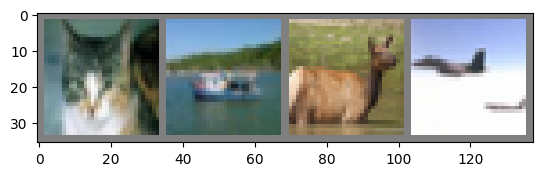

cat   ship  deer  plane


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주는 함수


def imshow(img):
    img = img / 2 + 0.5    # 이미지 보기좋게 조정(정규화된 값을 보정)
    
    #  np.transpose 함수는 NumPy 배열의 차원 순서를 변경
    #  이미지를 시각화할 때는 보통 (높이, 너비, 채널 수) 형태로 변경
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 랜덤으로 트레인 이미지 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보기
imshow(torchvision.utils.make_grid(images))
# 라벨 프린트
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### CNN 신경망 정의

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 순전파에 사용되는 요소들 정의
        
        
        # 입력 채널이 3개이고 출력 채널이 6개인 5x5 크기의 컨볼루션 필터
        self.conv1 = nn.Conv2d(3, 6, 5) 
        
        #  2x2 크기의 맥스 풀링 연산을 정의
        # 맥스 풀링은 이미지를 작게 만들어주고 중요한 정보를 강조
        self.pool = nn.MaxPool2d(2, 2)
        
        # 입력 채널이 6개이고 출력 채널이 16개인 5x5 크기의 컨볼루션 필터를 정의
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # 6x5x5 크기의 특성맵을 1차원으로 펼친 후, 120개의 뉴런을 가지는 fully connected 층 정의
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        #  120개의 뉴런을 가지는 또 다른 완전 연결 층을 정의
        self.fc2 = nn.Linear(120, 84)
        
        # 84개의 뉴런을 가지며, 10개의 출력을 내는 완전 연결 층을 정의
        self.fc3 = nn.Linear(84, 10)

        
    # 순전파 함수
    def forward(self, x):
        
        # x를 conv1층에 통과시킨다 (활성화 함수로 ReLu사용)
        x = self.pool(F.relu(self.conv1(x)))
        
        # x를 cov2층 통과시킨후 (활성함수 ReLu) pool 통해 이미지 작게 만들기
        x = self.pool(F.relu(self.conv2(x)))
        
        # 모든 차원을 제외하고 평탄화
        x = torch.flatten(x, 1) 
        
        # fc1 층을 통과하여 120개의 뉴런을 가진 완전 연결 층 통과
        x = F.relu(self.fc1(x))
        
        #  ReLU와 fc2 층을 거친다
        x = F.relu(self.fc2(x))
        
        # 최종 fc3 층을 거쳐 10개의 출력을 얻기
        x = self.fc3(x)
        return x


net = Net()

### 손실 함수와 옵티마이저 정의

In [18]:
import torch.optim as optim

# 손실함수 정의
# 다중 클래스 분류에 사용하는 크로스 엔트로피 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의
# 확률적 경사 하강법(SGD), 학습률(매개변수 얼마나 크게 업데이트?) = 0.001, 모멘텀은 이전에 이동한 방향에선 가속도 내주는 역할
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 트레이닝

In [ ]:
for epoch in range(20):
    running_loss = 0.0  # 손실을 누적할 변수를 초기화

    # trainloader에서 미니 배치를 하나씩 가져와 학습을 진행
    for i, data in enumerate(trainloader, 0):
        # 미니 배치에서 입력과 레이블을 가져오기
        inputs, labels = data

        # 매개변수의 그래디언트를 초기화
        optimizer.zero_grad()

        # 순전파(forward) + 역전파(backward) + 매개변수 업데이트를 수행
        outputs = net(inputs)   # 신경망에 입력을 전달하여 출력을 얻기
        loss = criterion(outputs, labels)   # 손실 함수를 사용하여 예측과 실제 레이블 사이의 손실을 계산
        loss.backward()   # 손실의 그래디언트를 계산
        optimizer.step()   # 옵티마이저를 사용하여 신경망의 매개변수를 업데이트

        # 통계 정보를 출력
        running_loss += loss.item()
        if i % 2000 == 1999:   # 매 2000개의 미니 배치마다 손실을 출력합니다.
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


print('Finished Training')

[1,  2000] loss: 1.156
[1,  4000] loss: 1.147
[1,  6000] loss: 1.161
[1,  8000] loss: 1.130
[1, 10000] loss: 1.126
[1, 12000] loss: 1.154
[2,  2000] loss: 1.137
[2,  4000] loss: 1.150
[2,  6000] loss: 1.161
[2,  8000] loss: 1.154
[2, 10000] loss: 1.146
[2, 12000] loss: 1.145
[3,  2000] loss: 1.127
[3,  4000] loss: 1.159
[3,  6000] loss: 1.167
[3,  8000] loss: 1.138
[3, 10000] loss: 1.143
[3, 12000] loss: 1.146
[4,  2000] loss: 1.142
[4,  4000] loss: 1.152
[4,  6000] loss: 1.135
[4,  8000] loss: 1.163
[4, 10000] loss: 1.137
[4, 12000] loss: 1.144
[5,  2000] loss: 1.144
[5,  4000] loss: 1.157
[5,  6000] loss: 1.137
[5,  8000] loss: 1.143
[5, 10000] loss: 1.142
[5, 12000] loss: 1.143
[6,  2000] loss: 1.146
[6,  4000] loss: 1.125
[6,  6000] loss: 1.151
[6,  8000] loss: 1.143
[6, 10000] loss: 1.164
[6, 12000] loss: 1.162
[7,  2000] loss: 1.141
[7,  4000] loss: 1.154
[7,  6000] loss: 1.133
[7,  8000] loss: 1.153
[7, 10000] loss: 1.159
[7, 12000] loss: 1.133
[8,  2000] loss: 1.158
[8,  4000] 

### 모델 저장

In [20]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 학습이 제대로 되었는지 확인

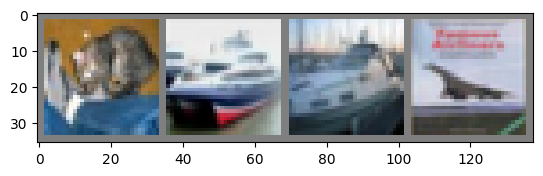

GroundTruth:  cat   ship  ship  plane


In [21]:
dataiter = iter(testloader) # 데이터를 순회 가능한(iterable) 객체로 변환
images, labels = next(dataiter)

# 이미지 보기
imshow(torchvision.utils.make_grid(images))
#  labels 리스트에서 처음 4개 레이블에 해당하는 클래스 이름을 문자열로 변환하여 출력
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### 저장했던 모델 불러오기

In [22]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### 모델에 이미지 돌려보기

In [23]:
outputs = net(images)

### 이미지를 분류한 결과를 출력

In [24]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   plane


### 신경망 모델 성능 평가

In [25]:
correct = 0
total = 0
# 그라디언트를 계산하지 않도록 설정
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 테스트 데이터를 모델에 입력하여 예측
        outputs = net(images)
        # 예측된 클래스 레이블을 계산
        # outputs.data는 모델의 출력 텐서, torch.max를 사용하여 최댓값과 해당 인덱스를 구함
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # 예측과 실제 레이블이 일치하는 경우를 카운트
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


### 각 클래스 별 정확도

In [26]:
# 각 클래스별 정확도 계산하기
# 다시 한번 그라디언트가 필요하지 않으므로 torch.no_grad() 내에서 실행
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 클래스별로 정확히 분류된 이미지 개수를 세고 총 이미지 개수를 카운트
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# 각 클래스별 정확도 출력
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 69.7 %
Accuracy for class: car   is 77.6 %
Accuracy for class: bird  is 42.5 %
Accuracy for class: cat   is 28.5 %
Accuracy for class: deer  is 48.5 %
Accuracy for class: dog   is 47.6 %
Accuracy for class: frog  is 75.0 %
Accuracy for class: horse is 57.8 %
Accuracy for class: ship  is 53.6 %
Accuracy for class: truck is 67.0 %
